In [1]:
import pandas
import geopandas 
from   pyproj import CRS
import matplotlib.pyplot as plt
from   matplotlib.pyplot import imread
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from   shapely.geometry import Point, LineString, Polygon, MultiPoint

import requests
from   zipfile import ZipFile
import datetime 
import math

from local_module import NhcDownloaderBot, MapTemplate, NhcRssParser, align_paragraph, feature_distance, tc_legend, fecha_hora, calcBearing

%matplotlib inline

In [2]:
nch_dl       = NhcDownloaderBot()
map_template = MapTemplate()

In [3]:
df = nch_dl.gdf_file(18, 2021)

No TC found
Area 1 se vigila? False


/home/jmedinah/miniconda3/envs/unidata/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/jmedinah/miniconda3/envs/unidata/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


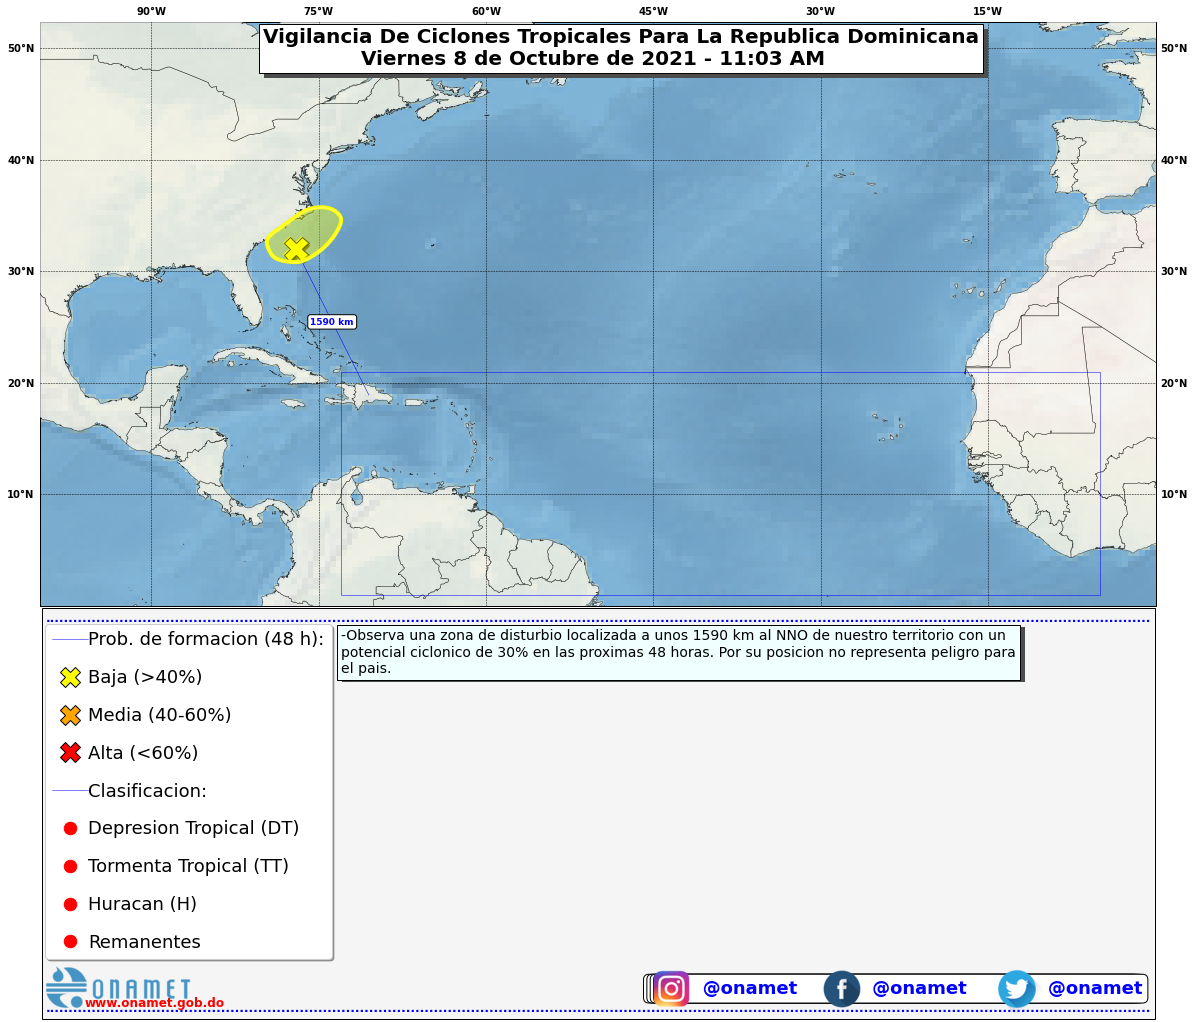

In [4]:
fig, ax = map_template.wide_map()
ax = tc_legend(ax)
fecha_y_hora = fecha_hora(ax)

gtwo_areas_gdf  = nch_dl.gtwo_areas_gdf .loc[nch_dl .gtwo_areas_gdf  ['BASIN']     == 'Atlantic']
gtwo_lines_gdf  = nch_dl.gtwo_lines_gdf .loc[nch_dl .gtwo_lines_gdf  ['BASIN']     == 'Atlantic']
gtwo_points_gdf = nch_dl.gtwo_points_gdf.loc[nch_dl .gtwo_points_gdf ['BASIN']     == 'Atlantic']

polygon = Polygon([(-73, 1), (-73, 21), (-5, 21), (-5, 1), (-73, 1)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=gtwo_areas_gdf.crs)
ax.add_geometries(poly_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
                  edgecolor='b', linewidth=0.5, zorder = 100)

#https://matplotlib.org/stable/tutorials/advanced/patheffects_guide.html
url    = 'https://www.nhc.noaa.gov/index-at.xml'
tcdict, tclist = {}, []
try:
    tcdict, tclist = NhcRssParser(url).tc_dict_list()
    for key, value in tcdict.items():
        lat, lon = tcdict[key][2]
        name = tcdict[key][0]
        ax.scatter(lon, lat, transform=map_template.data_crs, color = 'red', marker = '.', s=1500,
                   path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='k', alpha=1)], zorder = 100000)
        t = ax.text(lon, lat+1.5, name.upper(), transform=ax.transData, fontsize=16, verticalalignment='center', 
                horizontalalignment='center', weight = 'bold', color = 'w', zorder = 10000)
        t.set_path_effects([path_effects.PathPatchEffect(offset=(2, -2), facecolor='k'),
                            path_effects.PathPatchEffect(edgecolor='k', linewidth=0.2, facecolor='w')])

        p  = Point(lon, lat)
        inside = p.within(polygon)
        if inside == True:
            value.append('Vigila')
    else:
        value.append('Informa que') 
    print(name, 'se vigila?', p.within(polygon)) 
    
    ax, distance = feature_distance(lat, lon, ax)
    value.append(distance)
    
    bearing = calcBearing(lat, lon)
    value.append(bearing)
except:
    print('No TC found')

#***********************************************************************************************************************
prob_colors ={
                'Low'   : 'yellow',
                'Medium': 'orange',
                'High'  : 'red'
             }
for prob_type in prob_colors.keys():
    prob_subset_areas  = gtwo_areas_gdf[gtwo_areas_gdf['RISK2DAY']  == prob_type]
    prob_subset_points = gtwo_points_gdf[gtwo_points_gdf['RISK2DAY']== prob_type]
    prob_subset_lines  = gtwo_lines_gdf[gtwo_lines_gdf['RISK2DAY']  == prob_type]
    ax.add_geometries(prob_subset_areas['geometry'], facecolor='none',
                      edgecolor=prob_colors[prob_type], crs=map_template.data_crs, 
                      linewidth=4, zorder = 10000)
    ax.add_geometries(prob_subset_areas['geometry'], facecolor=prob_colors[prob_type],
                      edgecolor='w', crs=map_template.data_crs, linewidth=1, alpha = 0.4, zorder = 10000)
    ax.scatter(prob_subset_points['geometry'].x, prob_subset_points['geometry'].y,
               transform=map_template.data_crs, color = prob_colors[prob_type], 
               s=550, marker = 'X', zorder = 10000,
               path_effects=[path_effects.withSimplePatchShadow(offset=(3,-3), alpha=1)])
    ax.add_geometries(prob_subset_lines['geometry'], crs=map_template.data_crs, facecolor='none', 
                      edgecolor=prob_colors[prob_type], linewidth=2, zorder = 10000)
if gtwo_points_gdf.empty:
    print('No points')
else:
    ax.plot(gtwo_points_gdf['geometry'].x, gtwo_points_gdf['geometry'].y, transform=map_template.data_crs, 
            markersize=25, marker = 'X', markeredgecolor='black', markerfacecolor='none', 
            linestyle='none', zorder = 10000)
lon = list(gtwo_points_gdf['geometry'].x)
lat = list(gtwo_points_gdf['geometry'].y)
for i, coords in enumerate(zip(lon, lat)):
    point = Point(coords)
    point_gdf = geopandas.GeoDataFrame([1], geometry=[point], crs=gtwo_areas_gdf.crs)
    inside = list(point_gdf['geometry'])[0].within(list(poly_gdf['geometry'])[0]) 
    if inside == True:
        tcdict[f'Area {str(i+1)}'] = ['Vigila'] 
    else:
        tcdict[f'Area {str(i+1)}'] = ['Observa']
    print(f'Area {str(i+1)} se vigila? {inside}')

    lat, lon = coords[1], coords[0]
    ax, distance = feature_distance(lat, lon, ax)
    tcdict[f'Area {str(i+1)}'].append(distance)
    
    bearing = calcBearing(lat, lon)
    tcdict[f'Area {str(i+1)}'].append(bearing)
#************************************************************************************************************************
props = dict(facecolor='azure', path_effects=[path_effects.withSimplePatchShadow(offset=(5,-2), alpha=1)])
p = 0
xtxt = 0.27
ytxt = -0.04
for key, value in tcdict.items():
    if 'AL' in key:
        if tcdict[key][8] == 'Vigila':
            recomendacion = 'Por su posicion se recomienda estar atentos a nuestros proximos boletines.'
            props = dict(facecolor='lightcyan', path_effects=[path_effects.withSimplePatchShadow(offset=(5,-2), alpha=1)])
            word_1 = 'que'
        else:
            recomendacion = 'Por su posicion no representa peligro para nuestro territorio.' 
            word_1 = ''
            
        text = (f'''-{tcdict[key][8]} {tcdict[key][1]} {tcdict[key][0]} {word_1} se ubica a unos \
{tcdict[key][9]} km al {tcdict[key][10]} del pais, posee vientos maximos \nsostenidos de \
{tcdict[key][5]}, moviendose al {tcdict[key][3]}. Su presion minima central es \
de {tcdict[key][4]}. \n{recomendacion}''')
        ax.text(xtxt, ytxt, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, 
                color = 'black', zorder = 100)
        ytxt = ytxt -0.1
    else:    
        if tcdict[key][0] == 'Vigila':
            recomendacion = 'Por su posicion se recomienda estar atentos a las nuestros\nproximos boletines.'
        else:
            recomendacion = 'Por su posicion no representa peligro para\nel pais.'
            
        text = (f'''-{tcdict[key][0]} una zona de disturbio localizada a unos {tcdict[key][1]} km al \
{tcdict[key][2]} de nuestro territorio con un\npotencial ciclonico de {gtwo_points_gdf['PROB2DAY'][0]} \
en las proximas 48 horas. {recomendacion}''')   
        ax.text(xtxt, ytxt, text.rjust(10), transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, 
                color = 'black', zorder = 100)  
        ytxt = ytxt -0.1
   

In [5]:
#LAURA 2020
track_line_gdf_a        = geopandas.read_file('example_shp/al132020_5day_011/al132020-011_5day_lin.shp')
cone_gdf_a              = geopandas.read_file('example_shp/al132020_5day_011/al132020-011_5day_pgn.shp')
points_gdf_a            = geopandas.read_file('example_shp/al132020_5day_011/al132020-011_5day_pts.shp')

init_radii_gdf_a        = geopandas.read_file('example_shp/al132020_fcst_011/al132020_2020082215_initialradii.shp')
fcst_radii_gdf_a        = geopandas.read_file('example_shp/al132020_fcst_011/al132020_2020082215_forecastradii.shp')

best_track_points_gdf_a = geopandas.read_file('example_shp/al132020_best_track/AL132020_pts.shp')
best_track_line_gdf_a   = geopandas.read_file('example_shp/al132020_best_track/AL132020_lin.shp')
best_track_radii_gdf_a  = geopandas.read_file('example_shp/al132020_best_track/AL132020_radii.shp')
best_track_swath_gdf_a  = geopandas.read_file('example_shp/al132020_best_track/AL132020_windswath.shp')

wsp_34_gdf_a            = geopandas.read_file('example_shp/2020082212_wsp_120hr/2020082212_wsp34knt120hr_5km.shp')
wsp_50_gdf_a            = geopandas.read_file('example_shp/2020082212_wsp_120hr/2020082212_wsp50knt120hr_5km.shp')
wsp_64_gdf_a            = geopandas.read_file('example_shp/2020082212_wsp_120hr/2020082212_wsp64knt120hr_5km.shp')

gtwo_areas_gdf_a        = geopandas.read_file('example_shp/gtwo_shapefiles/gtwo_areas_202108261157.shp')
gtwo_lines_gdf_a        = geopandas.read_file('example_shp/gtwo_shapefiles/gtwo_lines_202108261157.shp')
gtwo_points_gdf_a       = geopandas.read_file('example_shp/gtwo_shapefiles/gtwo_points_202108261157.shp')

In [6]:
#MICHAEL 2018
track_line_gdf_b   = geopandas.read_file('zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_lin.shp')
cone_gdf_b         = geopandas.read_file('zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_pgn.shp')
points_gdf_b       = geopandas.read_file('zip://./example_shp/michael_2018/al142018_5day_012.zip!al142018-012_5day_pts.shp')

init_radii_gdf_b   = geopandas.read_file('zip://./example_shp/michael_2018/al142018_fcst_012.zip!al142018_2018100915_initialradii.shp')
fcst_radii_gdf_b   = geopandas.read_file('zip://./example_shp/michael_2018/al142018_fcst_012.zip!al142018_2018100915_forecastradii.shp')

# best_track_points_gdf = geopandas.read_file('example_shp/michael_2018')
# best_track_line_gdf   = geopandas.read_file('example_shp/michael_2018')
# best_track_radii_gdf  = geopandas.read_file('example_shp/michael_2018')
# best_track_swath_gdf  = geopandas.read_file('example_shp/michael_2018')

# wsp_34_gdf            = geopandas.read_file('example_shp/michael_2018')
# wsp_50_gdf            = geopandas.read_file('example_shp/michael_2018')
# wsp_64_gdf            = geopandas.read_file('example_shp/michael_2018')

In [7]:
def gtwo_plot(ax, gtwo_points_gdf, gtwo_lines_gdf,gtwo_areas_gdf):
    prob_colors ={
                'Low'   : 'yellow',
                'Medium': 'orange',
                'High'  : 'red'
                 }
    for prob_type in prob_colors.keys():
        prob_subset_areas  = gtwo_areas_gdf[gtwo_areas_gdf['RISK2DAY']  == prob_type]
        prob_subset_points = gtwo_points_gdf[gtwo_points_gdf['RISK2DAY']== prob_type]
        prob_subset_lines  = gtwo_lines_gdf[gtwo_lines_gdf['RISK2DAY']  == prob_type]
        ax.add_geometries(prob_subset_areas['geometry'], facecolor='none',
                          edgecolor=prob_colors[prob_type], crs=map_template.data_crs, 
                          linewidth=4, zorder = 10000)
        ax.add_geometries(prob_subset_areas['geometry'], facecolor=prob_colors[prob_type],
                          edgecolor='w', crs=map_template.data_crs, linewidth=1, alpha = 0.4, zorder = 10000)
        ax.scatter(prob_subset_points['geometry'].x, prob_subset_points['geometry'].y,
                   transform=map_template.data_crs, color = prob_colors[prob_type], 
                   s=550, marker = 'X', zorder = 10001,
                   path_effects=[path_effects.withSimplePatchShadow(offset=(3,-3), alpha=1)])
        ax.add_geometries(prob_subset_lines['geometry'], crs=map_template.data_crs, facecolor='none', 
                          edgecolor=prob_colors[prob_type], linewidth=2, zorder = 10001)
    if gtwo_points_gdf.empty:
        print('No points')
    else:
        ax.plot(gtwo_points_gdf['geometry'].x, gtwo_points_gdf['geometry'].y, transform=map_template.data_crs, 
                markersize=25, marker = 'X', markeredgecolor='black', markerfacecolor='none', 
                linestyle='none', zorder = 10001)
    return ax

def cone_plot(ax, cone_gdf, track_line_gdf, points_gdf, init_radii_gdf=None,  fcst_radii_gdf=None, plot_radii=False):
    ax.add_geometries(cone_gdf['geometry'], crs=map_template.data_crs, facecolor='white',
                      edgecolor='none', alpha=0.3, zorder = 10001)
    ax.add_geometries(cone_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
                      edgecolor='w', linewidth=0.5, zorder = 10001)
    ax.add_geometries(track_line_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
                      edgecolor='b', linewidth=2, zorder = 10001)
    sc = ax.scatter(points_gdf['LON'], points_gdf['LAT'],transform=map_template.data_crs,
                    c='b', zorder = 10002)
    if plot_radii:
        ax.add_geometries(init_radii_gdf['geometry'], crs=map_template.data_crs, facecolor='brown',
                          edgecolor='none', linewidth=0.1, alpha=0.5, zorder = 10001)
        ax.add_geometries(fcst_radii_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
                          edgecolor='black', linewidth=1)
    return ax


/home/jmedinah/miniconda3/envs/unidata/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


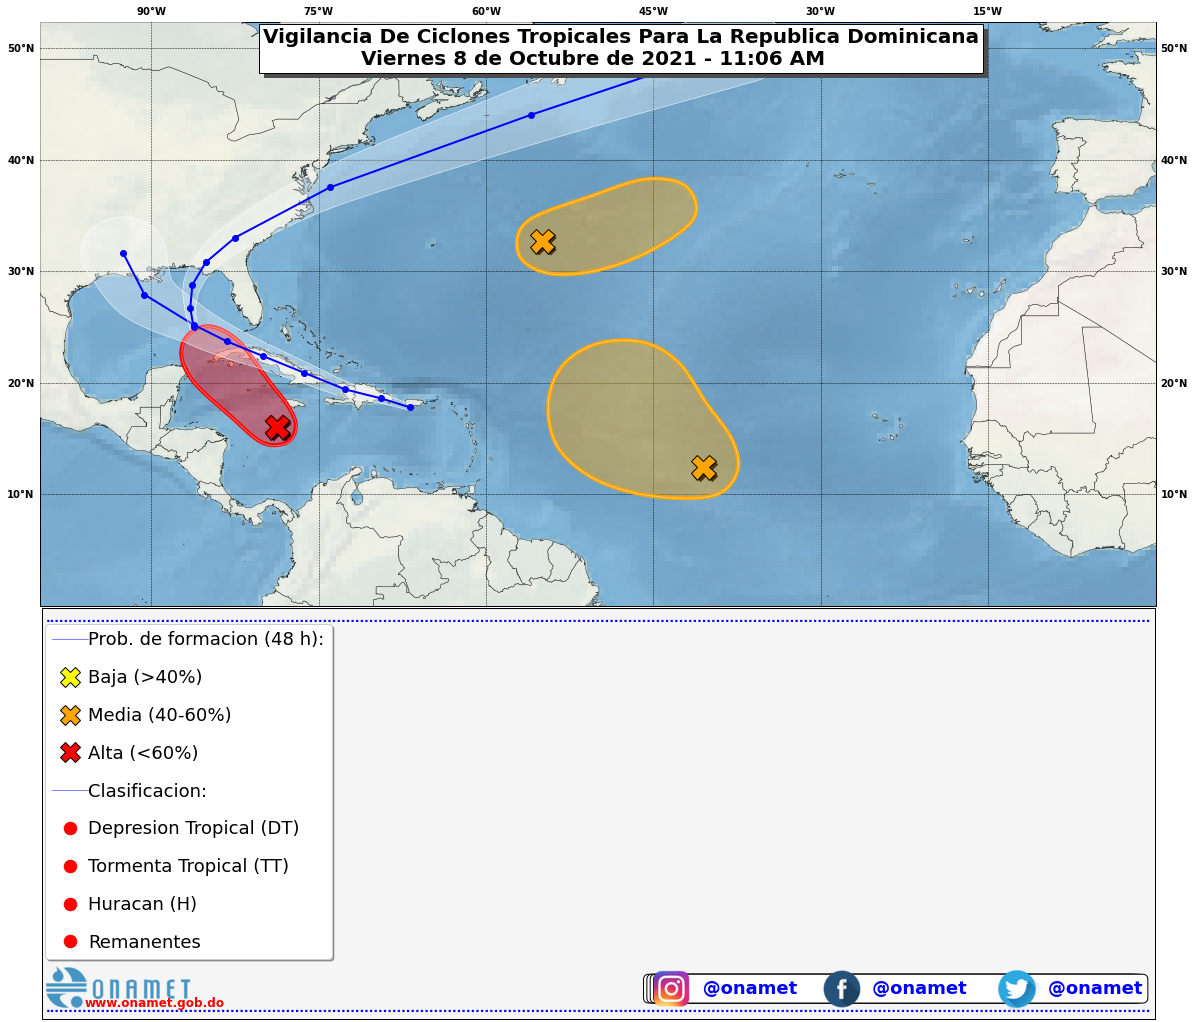

In [8]:
fig, ax = map_template.wide_map()
fecha_y_hora = fecha_hora(ax)
ax = tc_legend(ax)
ax = gtwo_plot(ax, gtwo_points_gdf_a, gtwo_lines_gdf_a, gtwo_areas_gdf_a)
ax = cone_plot(ax, cone_gdf_a, track_line_gdf_a, points_gdf_a, init_radii_gdf_a)
ax = cone_plot(ax, cone_gdf_b, track_line_gdf_b, points_gdf_b, init_radii_gdf_b)




<ipython-input-54-dd7ce6af81ba>:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fcst_radii_gdf_a_dis = fcst_radii_gdf_a_dis.buffer(buffer_distance, join_style=1).buffer(-buffer_distance, join_style=1)


/home/jmedinah/miniconda3/envs/unidata/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


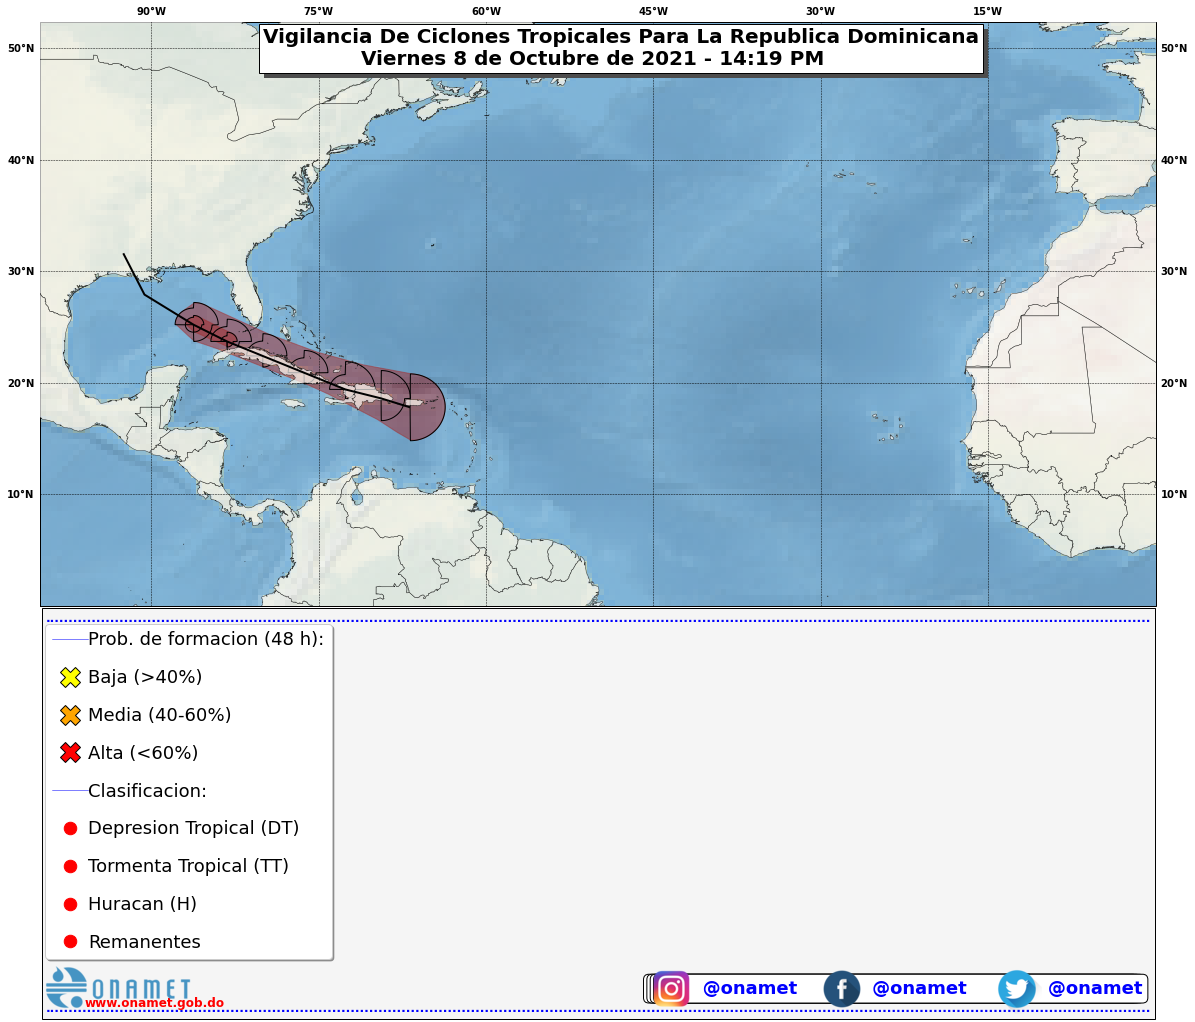

In [54]:
fig, ax = map_template.wide_map()
fecha_y_hora = fecha_hora(ax)
ax = tc_legend(ax)

#ax = cone_plot(ax, cone_gdf_a, track_line_gdf_a, points_gdf_a, init_radii_gdf_a, fcst_radii_gdf_a, plot_radii=True)
#ax = cone_plot(ax, cone_gdf_b, track_line_gdf_b, points_gdf_b)

# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a.to_crs("EPSG:32634")
# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a_buffer.buffer(distance=0.1)
# fcst_radii_gdf_a_buffer = fcst_radii_gdf_a_buffer.to_crs("EPSG:4035")

buffer_distance = 50
fcst_radii_gdf_a_dis = fcst_radii_gdf_a.dissolve(by='RADII')
# fcst_radii_gdf_a_dis = fcst_radii_gdf_a_dis.buffer(distance=1, join_style=1, cap_style=1).simplify(1)
fcst_radii_gdf_a_dis = fcst_radii_gdf_a_dis.buffer(buffer_distance, join_style=1).buffer(-buffer_distance, join_style=1)
ax.add_geometries(fcst_radii_gdf_a_dis, crs=map_template.data_crs,
                      facecolor='brown', edgecolor='brown', alpha=0.5)



ax.add_geometries(fcst_radii_gdf_a['geometry'], crs=map_template.data_crs, facecolor='none',
                   edgecolor='black', linewidth=1)
ax.add_geometries(track_line_gdf_a['geometry'], crs=map_template.data_crs, facecolor='none',
                      edgecolor='k', linewidth=2, zorder = 10001)


# track_line_gdf_a_buffer = track_line_gdf_a.to_crs("EPSG:32634")
# track_line_gdf_a_buffer = track_line_gdf_a_buffer.buffer(distance=150000)
# track_line_gdf_a_buffer = track_line_gdf_a_buffer.to_crs("EPSG:4035")
# ax.add_geometries(track_line_gdf_a_buffer, crs=map_template.data_crs,
#                       facecolor='#C8A2C8', alpha=1)
# ax.add_geometries(fcst_radii_gdf_a_buffer, crs=map_template.data_crs,
#                       facecolor='none', edgecolor='k', alpha=0.5)

In [53]:
fig, ax = map_template().wide_map()
silueta_rd_gdf_buffer = map_template.silueta_rd_gdf.to_crs("EPSG:32634")
silueta_rd_gdf_buffer = silueta_rd_gdf_buffer.buffer(distance=300000)
silueta_rd_gdf_buffer = silueta_rd_gdf_buffer.to_crs("EPSG:4035")
ax.add_geometries(silueta_rd_gdf_buffer, crs=map_template.data_crs,
                      facecolor='white', alpha=0.3)


TypeError: 'MapTemplate' object is not callable

In [55]:
fcst_radii_gdf_a

,RADII,STORMID,BASIN,STORMNUM,ADVNUM,VALIDTIME,SYNOPTIME,TIMEZONE,TAU,NE,SE,SW,NW,geometry
0,34.0,al132020,al,13.0,11,2020082215,2020082212,UTC,0.0,180.0,180.0,0.0,0.0,"POLYGON ((-66.77206 20.79453, -66.71619 20.793..."
1,34.0,al132020,al,13.0,11,2020082300,2020082212,UTC,12.0,150.0,120.0,0.0,0.0,"POLYGON ((-69.37667 21.09544, -69.33001 21.094..."
2,34.0,al132020,al,13.0,11,2020082312,2020082212,UTC,24.0,150.0,50.0,0.0,80.0,"POLYGON ((-72.57655 21.89544, -72.52962 21.894..."
3,34.0,al132020,al,13.0,11,2020082400,2020082212,UTC,36.0,120.0,60.0,0.0,80.0,"POLYGON ((-76.28110 22.89635, -76.24329 22.895..."
4,34.0,al132020,al,13.0,11,2020082412,2020082212,UTC,48.0,120.0,60.0,0.0,80.0,"POLYGON ((-79.98088 24.39635, -79.94263 24.395..."
5,34.0,al132020,al,13.0,11,2020082500,2020082212,UTC,60.0,120.0,60.0,0.0,80.0,"POLYGON ((-83.18067 25.69635, -83.14202 25.695..."
6,50.0,al132020,al,13.0,11,2020082500,2020082212,UTC,60.0,50.0,30.0,0.0,30.0,"POLYGON ((-83.19202 24.53182, -83.17607 24.531..."
7,34.0,al132020,al,13.0,11,2020082512,2020082212,UTC,72.0,120.0,90.0,40.0,90.0,"POLYGON ((-86.18042 27.19635, -86.14126 27.195..."
8,50.0,al132020,al,13.0,11,2020082512,2020082212,UTC,72.0,50.0,40.0,0.0,40.0,"POLYGON ((-86.19192 26.03181, -86.17577 26.031..."


In [11]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -20, 10, 40])
#ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
# ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
#                  edgecolor='none', alpha = 0.5)
# ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=0.5, alpha=0.7)
# ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=1, alpha=0.7)

ax.add_geometries(gdf_names[file_names[0]][1]['geometry'], crs=data_crs, facecolor='white',
                 edgecolor='black', linewidth=1, alpha=0.7)
ax.add_geometries(gdf_names[file_names[0]][0]['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2)
sc = ax.scatter(gdf_names[file_names[0]][2]['LON'], gdf_names[file_names[0]][2]['LAT'],transform=data_crs,
                zorder=10, c=gdf_names[file_names[0]][2]['MAXWIND'])
ax.add_geometries(gdf_names[file_names[1]][0]['geometry'], crs=data_crs, facecolor='brown',
                 edgecolor='none', linewidth=0.1, alpha=0.5)
ax.add_geometries(gdf_names[file_names[1]][1]['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1)

# ww_colors = {'TWA': 'yellow',
#              'HWA': 'pink',
#              'TWR': 'blue',
#              'HWR': 'tab:red'}

# for ww_type in ww_colors.keys():
#     ww_subset = ww_gdf[ww_gdf['TCWW']==ww_type]
#     ax.add_geometries(ww_subset['geometry'], facecolor='none',
#                      edgecolor=ww_colors[ww_type], crs=data_crs,
#                      linewidth=5)
#plt.colorbar(sc)

NameError: name 'map_crs' is not defined

<Figure size 1440x1440 with 0 Axes>

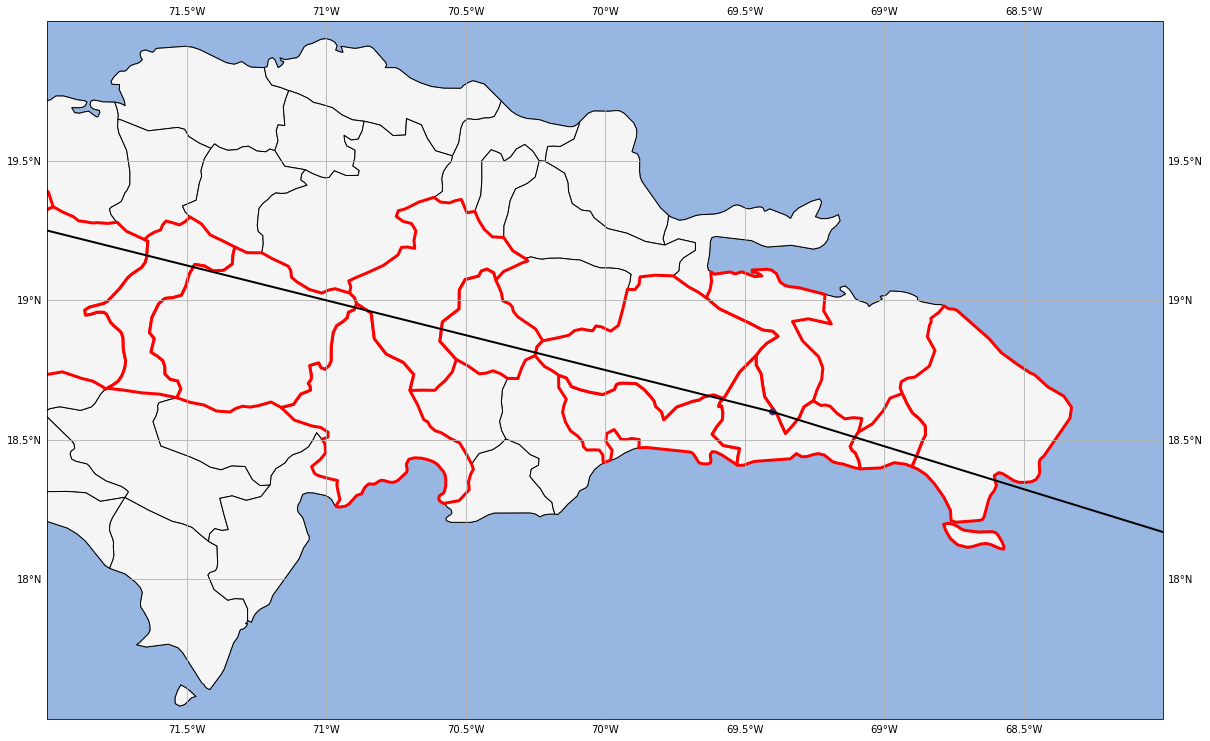

In [14]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)

ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


ax.add_geometries(track_line_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2, zorder = 100)
sc = ax.scatter(points_gdf['LON'], points_gdf['LAT'],transform=data_crs,
                zorder=100, c=points_gdf['MAXWIND'])
track = sgeom.LineString(zip(points_gdf['LON'], points_gdf['LAT']))

def colorize_state(geometry):
        #facecolor = (0.9375, 0.9375, 0.859375)
        edgecolor  =  'black'
        linewidth  =     1
        if geometry.intersects(track):
            #facecolor = 'red'
            edgecolor = 'red'
            linewidth =   3
        return {'facecolor': 'whitesmoke', 'edgecolor': edgecolor, 'linewidth': linewidth}
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, styler=colorize_state)
# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

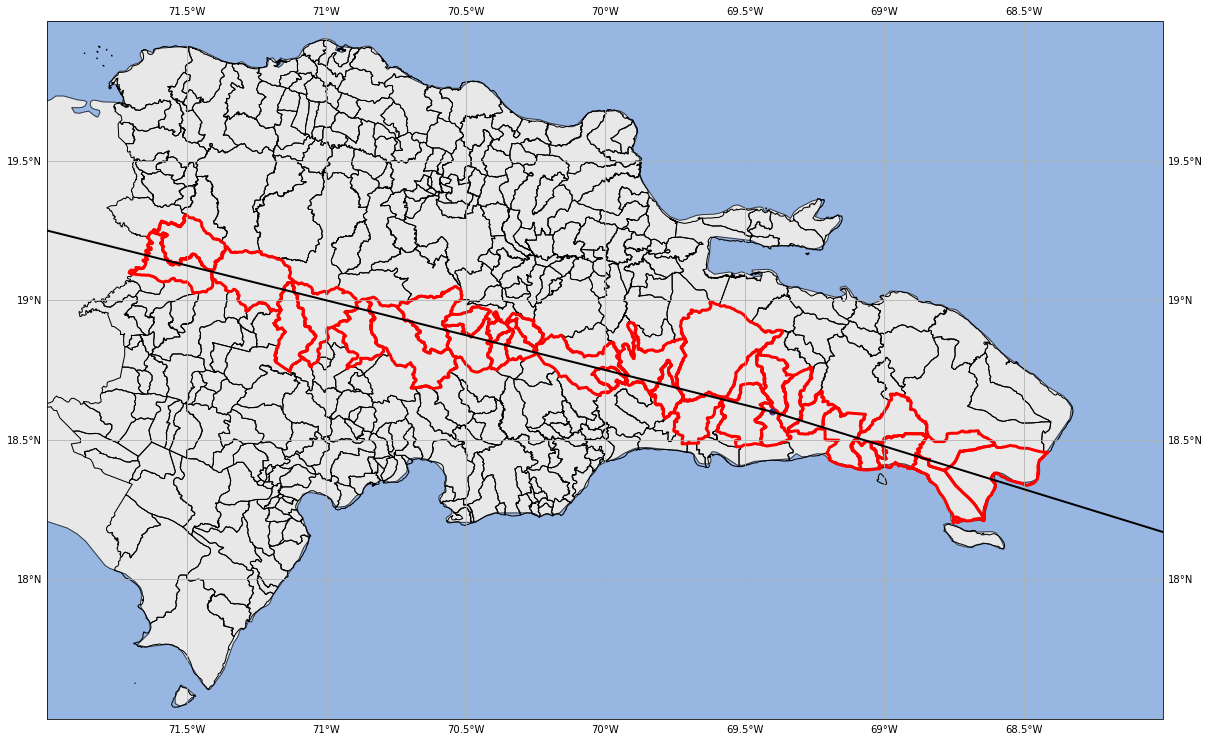

In [15]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)

ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


ax.add_geometries(track_line_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2, zorder = 100)
sc = ax.scatter(points_gdf['LON'], points_gdf['LAT'],transform=data_crs,
                zorder=100, c=points_gdf['MAXWIND'])
track = sgeom.LineString(zip(points_gdf['LON'], points_gdf['LAT']))

def colorize_state(geometry):
        #facecolor = (0.9375, 0.9375, 0.859375)
        edgecolor  =  'black'
        linewidth  =     1
        if geometry.intersects(track):
            #facecolor = 'red'
            edgecolor = 'red'
            linewidth =   3
        return {'edgecolor': edgecolor, 'linewidth': linewidth}

ax.add_geometries(división_prov_muni_y_dist_muni['geometry'], crs=data_crs, styler=colorize_state, facecolor='none')

# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

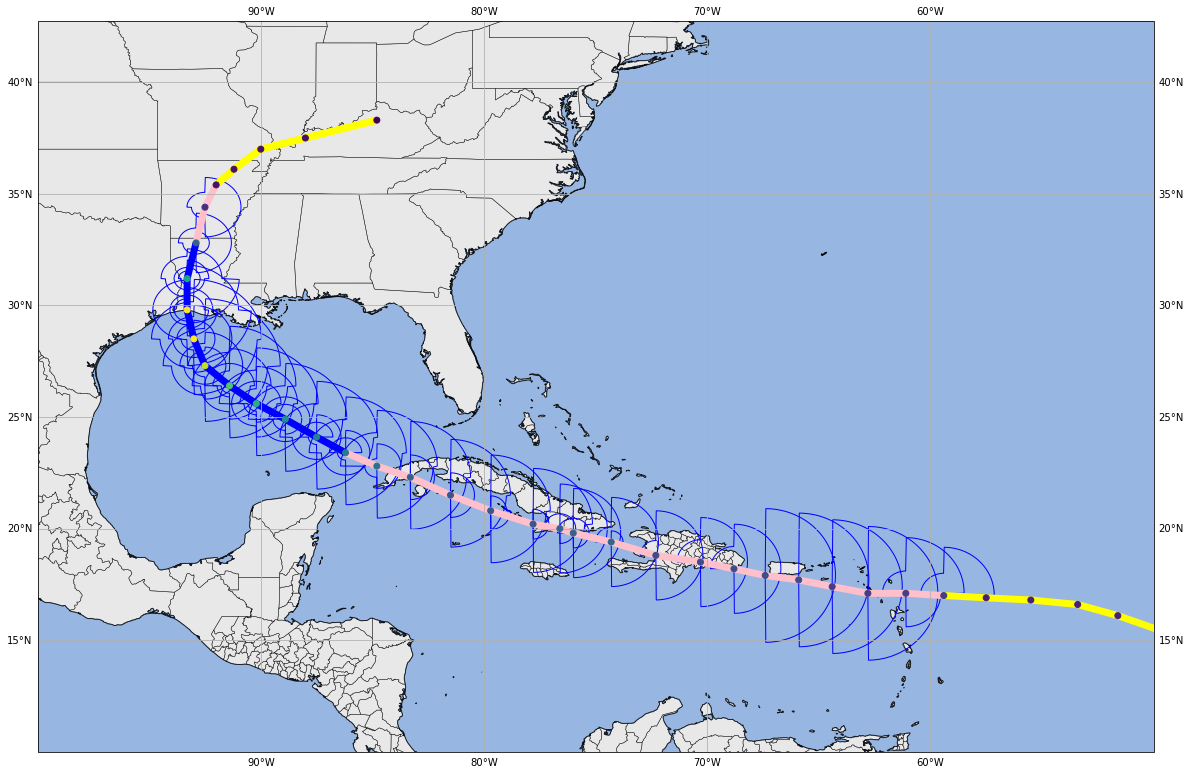

In [16]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


sc_2 = ax.scatter(best_track_points_gdf['LON'], best_track_points_gdf['LAT'],
                  transform=data_crs, zorder=10, c=best_track_points_gdf['INTENSITY'])
# ax.add_geometries(best_track_line_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='black', linewidth=2)
ax.add_geometries(best_track_radii_gdf['geometry'], crs=data_crs, facecolor='none',
                  edgecolor='blue')
# ax.add_geometries(best_track_swath_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='white')

btl_colors ={'TD': 'yellow',
             'TS': 'pink',
             'HU': 'blue',
             'MH': 'tab:red'}

for btl_type in btl_colors.keys():
    btl_subset = best_track_line_gdf[best_track_line_gdf['STORMTYPE']== btl_type]
    ax.add_geometries(btl_subset['geometry'], facecolor='none',
                     edgecolor=btl_colors[btl_type], crs=data_crs,
                     linewidth=7, alpha = 1)

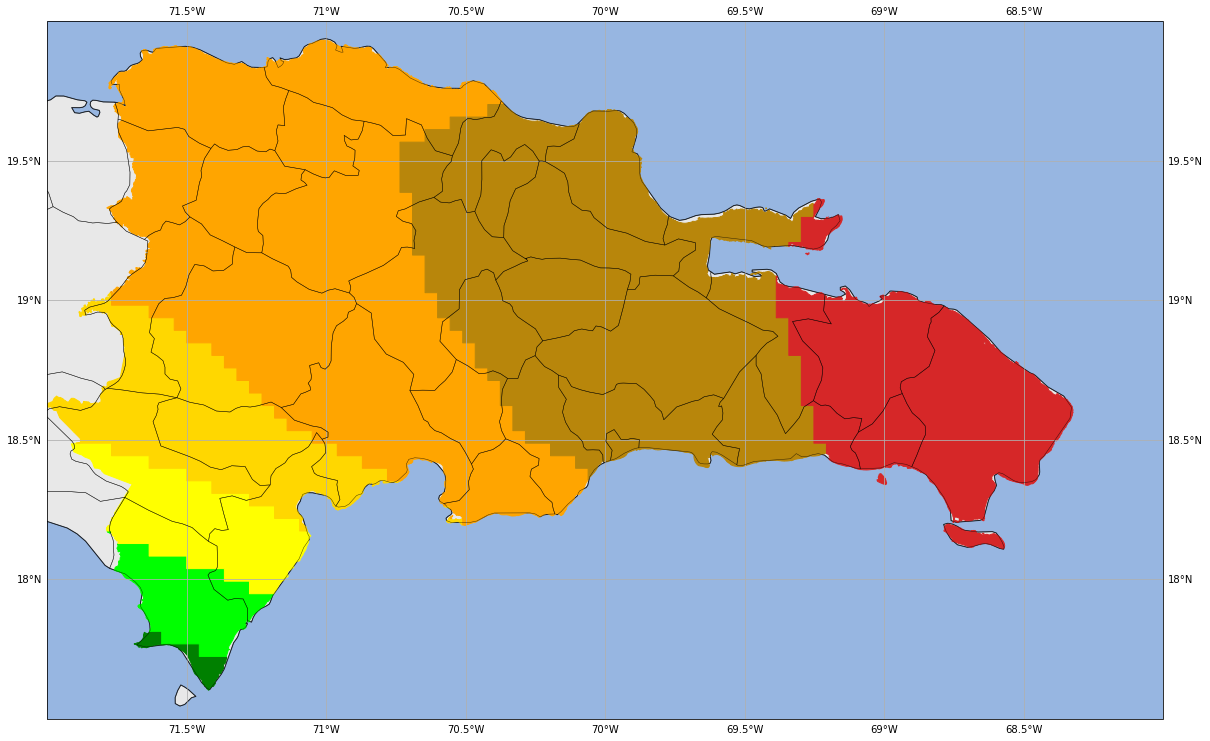

In [145]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

wsp_34_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_5km.shp')

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])

ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)
    

wsp_colors = {'<5%'   : 'none',   '5-10%' : 'darkgreen','10-20%': 'green', '20-30%' : 'lime',
              '30-40%': 'yellow', '40-50%': 'gold',     '50-60%': 'orange','60-70%' : 'darkgoldenrod',
              '70-80%': 'tab:red','80-90%': 'brown',    '>90%'  : 'purple'}

# for wsp_type in wsp_colors.keys():
#     wsp_subset = wsp_34_gdf[wsp_34_gdf['PERCENTAGE']== wsp_type]
#     ax.add_geometries(wsp_subset['geometry'], facecolor=wsp_colors[wsp_type],
#                      edgecolor=wsp_colors[wsp_type], crs=data_crs,
#                      linewidth=1, alpha = 1)


wsp_34_smoothed_gdf = wsp_34_gdf['geometry'].simplify(0, preserve_topology=True)
wsp_34_gdf['geometry'] = wsp_34_smoothed_gdf

wsp_34_gdf = geopandas.clip(wsp_34_gdf, PROVINCIAS_gdf.to_crs(4035))

# ax.add_geometries(wsp_34_smoothed_gdf, facecolor='none',
#                      edgecolor='black', crs=data_crs,
#                      linewidth=1)

for wsp_type in wsp_colors.keys():
    wsp_subset = wsp_34_gdf[wsp_34_gdf['PERCENTAGE']== wsp_type]
    _ = ax.add_geometries(wsp_subset['geometry'], facecolor=wsp_colors[wsp_type],
                     edgecolor=wsp_colors[wsp_type], crs=data_crs,
                     linewidth=1, alpha = 1)


0           Annotation(115, 37, '0.10000000149011612')
1         Annotation(115, 37.5, '0.10000000149011612')
2           Annotation(115, 38, '0.10000000149011612')
3         Annotation(115, 38.5, '0.10000000149011612')
4           Annotation(115, 39, '0.10000000149011612')
                             ...                      
5008     Annotation(-63.5, 18.5, '1.7999999523162842')
5009       Annotation(-63.5, 19, '0.6000000238418579')
5010     Annotation(-63.5, 19.5, '0.4000000059604645')
5011      Annotation(-63.5, 20, '0.20000000298023224')
5012    Annotation(-63.5, 20.5, '0.10000000149011612')
Length: 5013, dtype: object

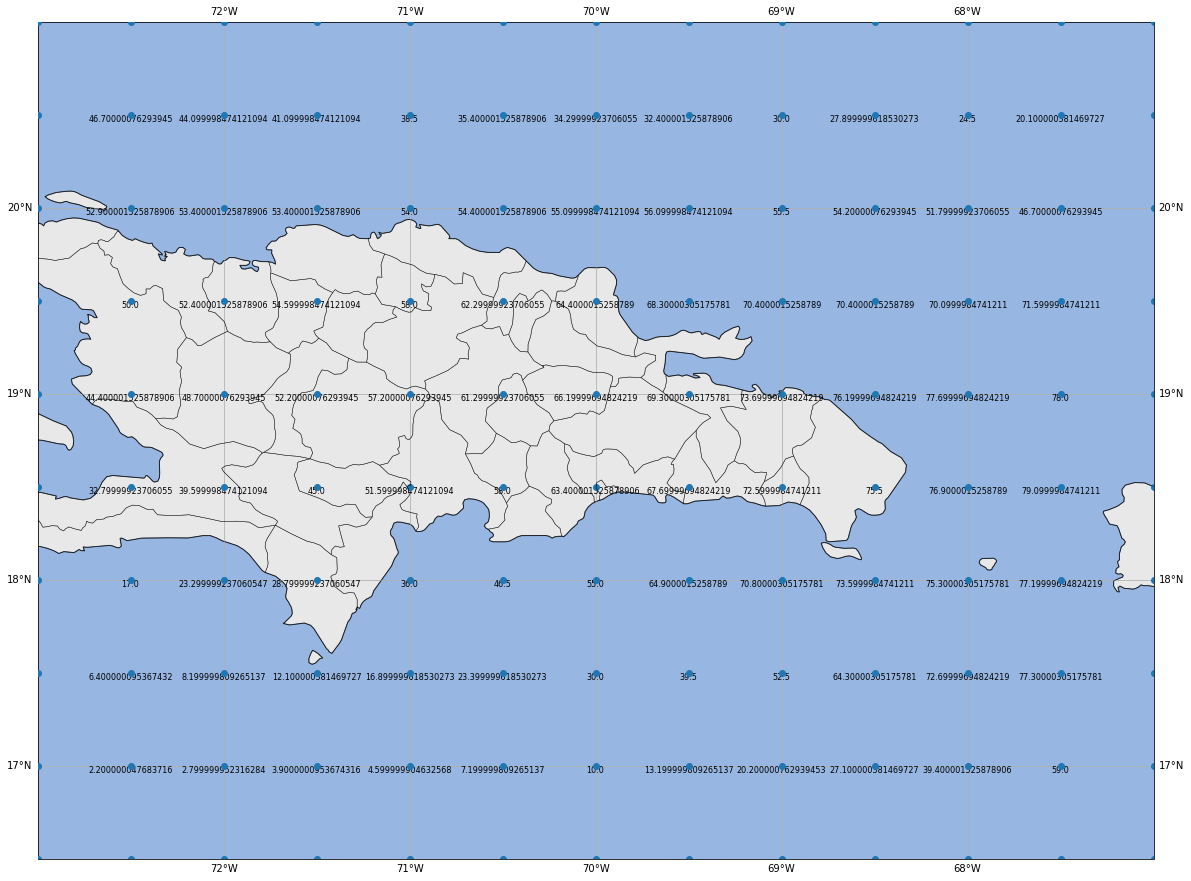

In [20]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-73, -67, 16.5, 21])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)

wsp_34_points_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp')
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(wsp_34_points_gdf["PWIND120"], downcast="float")
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf['PWIND120'] > 0]

ax.scatter(wsp_34_points_gdf['geometry'].x, wsp_34_points_gdf['geometry'].y,
                  transform=data_crs,  zorder=10)

wsp_34_points_gdf.apply(lambda x: ax.annotate(text=x.PWIND120, xy=(x.geometry.x, x.geometry.y), 
                                                fontsize = 8, ha='center', weight = 'normal', 
                                                va = 'top'), axis=1)
# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)

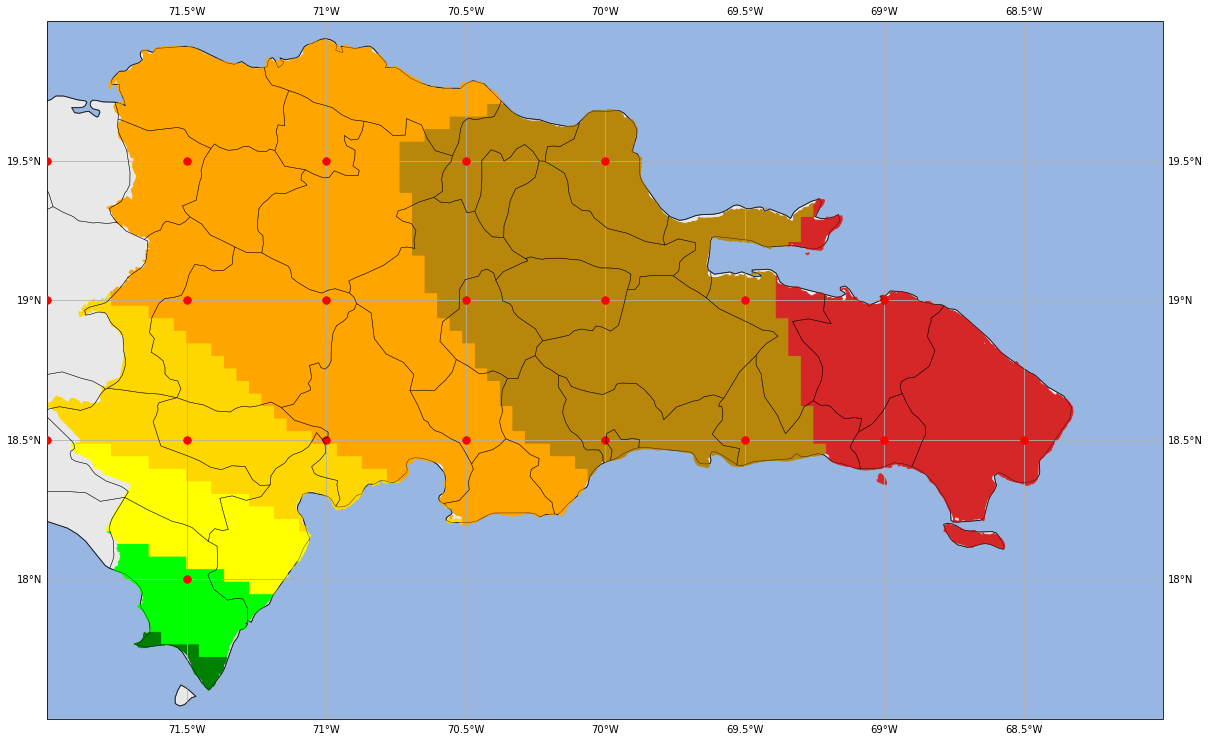

In [151]:
from shapely.ops import nearest_points

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, hispaniola_gdf.to_crs(4035))

ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
                  transform=data_crs,  color = 'red', s= 50, zorder=10)




fig

In [160]:
PROVINCIAS_gdf.apply(lambda x: nearest_points(Point(x['Longitud'],
                                                    x['Latitud']), list(wsp_34_clipped['geometry'])), 
                     axis=1)

AttributeError: 'list' object has no attribute '_geom'

In [164]:
type(list(wsp_34_clipped['geometry'])[0])

shapely.geometry.point.Point

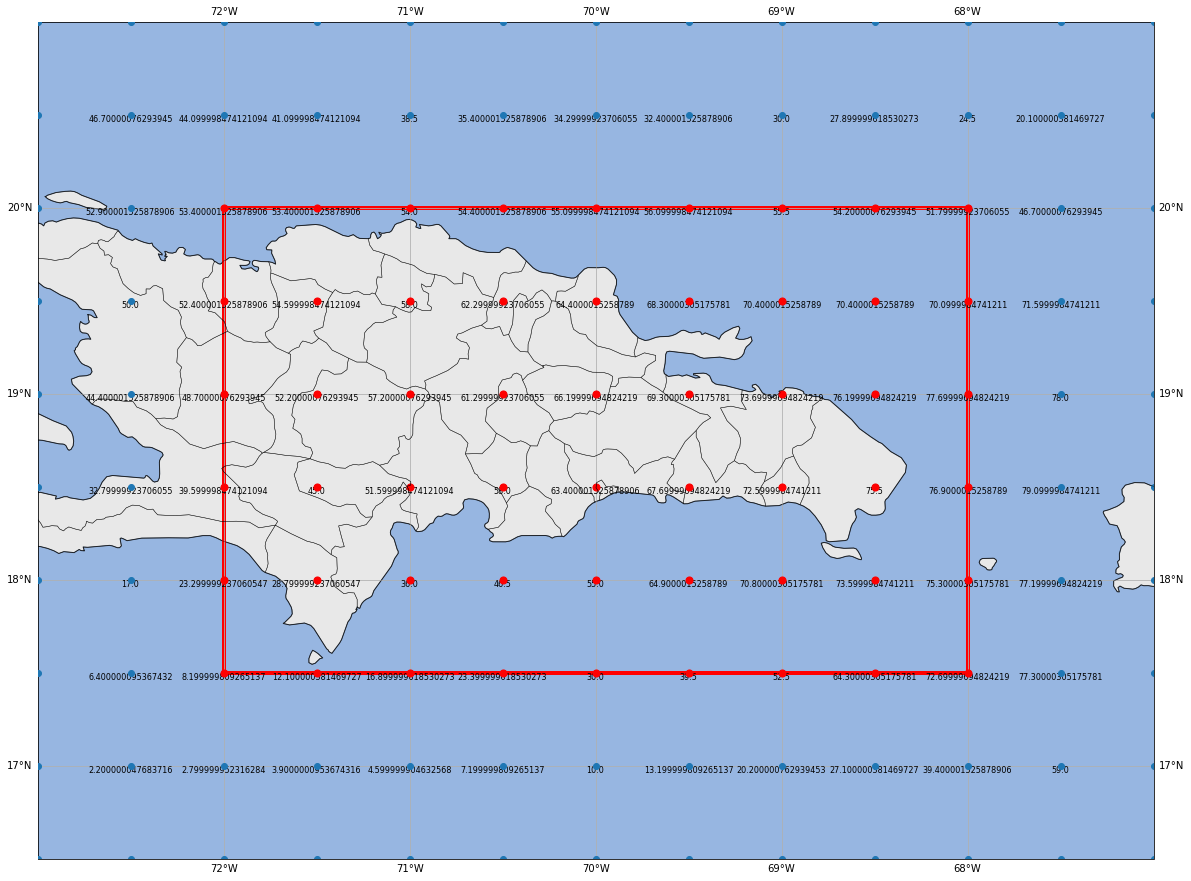

In [21]:
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
ax.add_geometries(poly_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='red', linewidth=4)
ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
                  transform=data_crs,  color = 'red', s= 50, zorder=10)
fig

In [22]:
x = np.array(wsp_34_clipped['geometry'].x)
y = np.array(wsp_34_clipped['geometry'].y)
points = list(zip(x, y))
values = wsp_34_clipped['PWIND120']


(-72.24489795918366,
 -67.75510204081634,
 17.346938775510203,
 20.153061224489797)

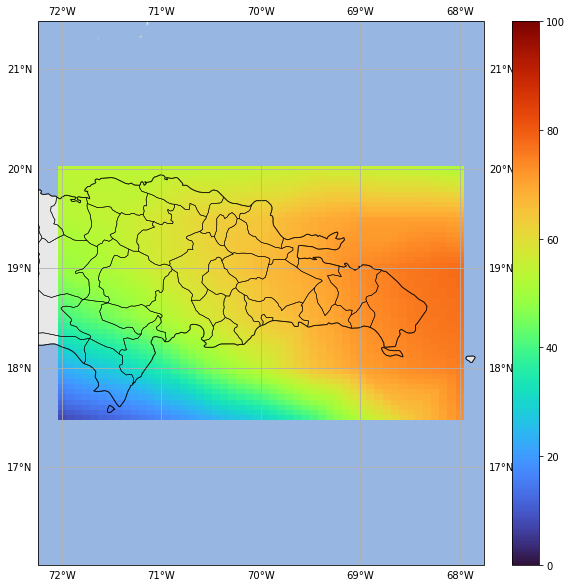

In [23]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax  = plt.subplot(1, 1, 1, projection = map_crs)


#ax.set_extent([-73, -67, 16.5, 21])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)

wsp_34_points_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp')
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(wsp_34_points_gdf["PWIND120"], downcast="float")
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf['PWIND120'] > 0]

# ax.scatter(wsp_34_points_gdf['geometry'].x, wsp_34_points_gdf['geometry'].y,
#                   transform=data_crs,  zorder=10)

# wsp_34_points_gdf.apply(lambda x: ax.annotate(text=round(x.PWIND120), xy=(x.geometry.x, x.geometry.y), 
#                                                 fontsize = 8, ha='center', weight = 'normal', 
#                                                 va = 'top'), axis=1)
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
# ax.add_geometries(poly_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='red', linewidth=4)
# ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
#                   transform=data_crs,  color = 'red', s= 50, zorder=10)


x = np.array(wsp_34_clipped['geometry'].x)
y = np.array(wsp_34_clipped['geometry'].y)
points = list(zip(x, y))
values = wsp_34_clipped['PWIND120']


X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = LinearNDInterpolator(points, values)
Z = interp(X, Y)

ax.set_extent([-90, -60, 15, 25], crs=data_crs)
pc = ax.pcolormesh(X, Y, Z, shading='auto', cmap = 'turbo', vmin = 0, vmax = 100, transform=data_crs)
# ax.plot(x, y, "ok")
#ax.legend()
plt.colorbar(pc)

ax.axis("equal")


In [24]:
Y

array([[17.5       , 17.5       , 17.5       , ..., 17.5       ,
        17.5       , 17.5       ],
       [17.55102041, 17.55102041, 17.55102041, ..., 17.55102041,
        17.55102041, 17.55102041],
       [17.60204082, 17.60204082, 17.60204082, ..., 17.60204082,
        17.60204082, 17.60204082],
       ...,
       [19.89795918, 19.89795918, 19.89795918, ..., 19.89795918,
        19.89795918, 19.89795918],
       [19.94897959, 19.94897959, 19.94897959, ..., 19.94897959,
        19.94897959, 19.94897959],
       [20.        , 20.        , 20.        , ..., 20.        ,
        20.        , 20.        ]])

In [25]:
# cmap = cmaps['Qualitative'] = ['none', 'darkgreen', 'green', 'Accent',
#                         'lime', 'yellow', 'gold', 'orange',
#                         'darkgoldenrod', 'tab:red', 'brown', 'purple']


cmap

NameError: name 'cmaps' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
viridis

In [ ]:
viridis(0.56)